In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from common import softmax, log_softmax, onehot
from llama2 import LLaMA2

In [8]:
def evaluate_ppl(model):
  # evaluate ppl on TinyStoriesV2-GPT4-valid dataset
  url = "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"
  local_path = os.path.join(tmpdir, os.path.basename(url))
  if not os.path.exists(local_path):
    download_file(url, local_path)

  with open(local_path) as f:
    stories = [x.strip() for x in f.read().split("<|endoftext|>") if x.strip()][:200]
    stories = "\n".join(stories)
  input_ids = model.tokenizer.encode(stories)

  # strided sliding window approach per https://huggingface.co/docs/transformers/perplexity
  max_len = model.ctx_size * 2
  input_ids = input_ids[:len(input_ids)//max_len*max_len]
  seq_len = len(input_ids)
  nlls = []
  for i in tqdm(range(0, seq_len, max_len)):
    x = input_ids[i:i+max_len]
    logits = model.forward(x, only_last=False)[:-1]
    labels = np.eye(model.hparams["vocab_size"], dtype=np.float32)[x[1:]]
    nlls.append(-(log_softmax(logits, axis=-1) * labels).sum(axis=-1))
  return np.exp(np.stack(nlls).mean(0))

In [9]:
tmpdir = "/tmp/pico-llama2"
model_type = "15M"

model = LLaMA2(model_type, kv_cache=False)
ppl = evaluate_ppl(model)

model_pi = LLaMA2(model_type, kv_cache=False, freq_scale=0.5)
ppl_pi = evaluate_ppl(model_pi)

dim = model.hparams["dim"] // model.hparams["n_heads"]
model_nkt = LLaMA2(model_type, kv_cache=False, freq_base=10000*2**(dim/(dim-2)))
ppl_nkt = evaluate_ppl(model_nkt)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

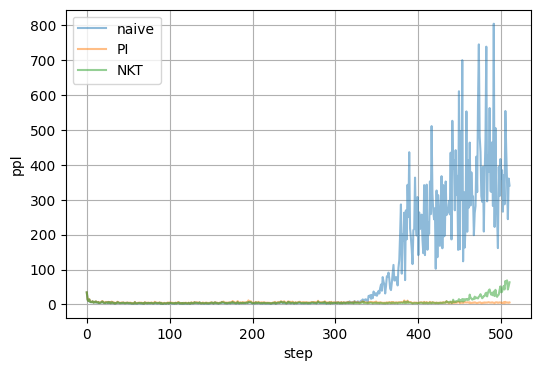

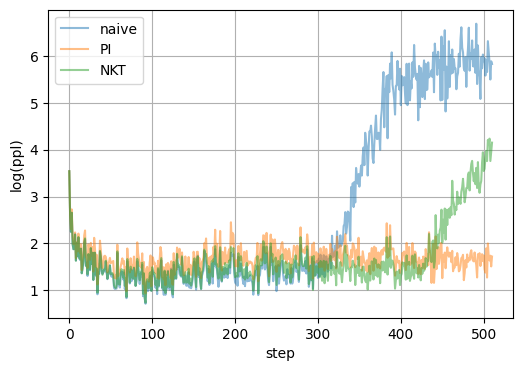

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(ppl)), ppl, alpha=0.5, label="naive")
plt.plot(range(len(ppl_pi)), ppl_pi, alpha=0.5, label="PI")
plt.plot(range(len(ppl_nkt)), ppl_nkt, alpha=0.5, label="NKT")
plt.xlabel("step"); plt.ylabel("ppl")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(len(ppl)), np.log(ppl), alpha=0.5, label="naive")
plt.plot(range(len(ppl_pi)), np.log(ppl_pi), alpha=0.5, label="PI")
plt.plot(range(len(ppl_nkt)), np.log(ppl_nkt), alpha=0.5, label="NKT")
plt.xlabel("step"); plt.ylabel("log(ppl)")
plt.legend(); plt.grid(); plt.show()

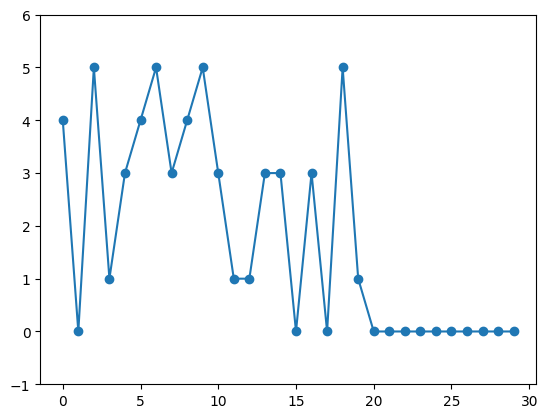

In [125]:
from decimal import Decimal, ROUND_DOWN

def fdecimical(x, n, base=5):
  return (x / (base**n)).to_integral_value(rounding=ROUND_DOWN) % base

base = Decimal(6)
X = Decimal(2**50)
N = np.arange(30)
y = [fdecimical(X, n, base) for n in N]

X_check = sum([x * base**i for i, x in zip(N, y)])
if X != X_check:
  print("!!!!!!!")
  print(X, X_check)
  print([x * base**i for i, x in zip(N, y)])

plt.scatter(N, y)
plt.plot(N, y)
plt.ylim((-1, base))
plt.show()

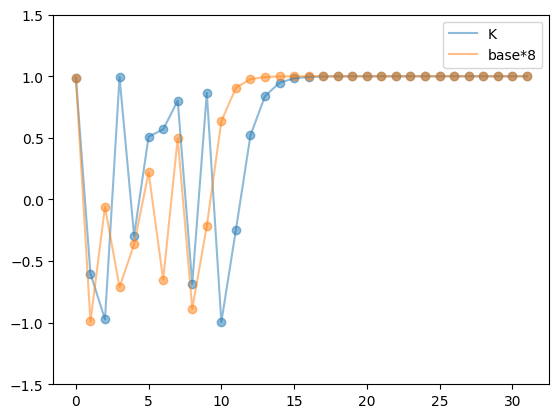

In [34]:
def fcos(x, n, base=10000**(2/32)):
  return np.cos(x / base**n)

def fsin(x, n, base=10000**(2/32)):
  return np.sin(x / base**n)

N = np.arange(32)
K = 1024
y = [fcos(K, n) for n in N]
plt.plot(N, y, alpha=0.5, label="K")
plt.scatter(N, y, alpha=0.5)

# y = [fcos(K*16, n) for n in N]
# plt.plot(N, y, alpha=0.5, label="K*16")
# plt.scatter(N, y, alpha=0.5)

y = [fcos(K, n, base=80000**(2/32)) for n in N]
plt.plot(N, y, alpha=0.5, label="base*8")
plt.scatter(N, y, alpha=0.5)

plt.ylim((-1.5, 1.5))
plt.legend()
plt.show()

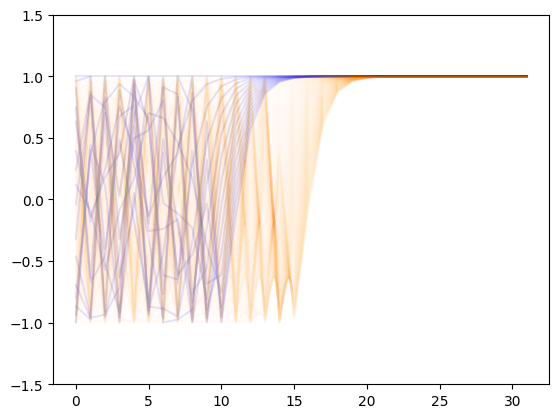

In [5]:
N = np.arange(32)
K = 1024
for k in range(0, K, 64):
  y = [fcos(k, n) for n in N]
  plt.plot(N, y, alpha=0.1, c="blue")
  
for k in range(0, K*16, 64):
  y = [fcos(k, n) for n in N]
  plt.plot(N, y, alpha=0.01, c="orange")

plt.ylim((-1.5, 1.5))
plt.show()

In [55]:
K_train = np.array(sum([[i] * (K-i) for i in range(0, K, 8)], []))
xx_train = np.arange(32).repeat(len(K_train))
yy_train = fcos(np.reshape(K_train, (-1, 1)), N.reshape(1, -1)).T.flatten()
#yy_train2 = fsin(np.reshape(K_train, (-1, 1)), N.reshape(1, -1)).T.flatten()

K_test = np.arange(K*16)
xx_test = np.arange(32).repeat(len(K_test))
yy_test = fcos(np.reshape(K_test, (-1, 1)), N.reshape(1, -1)).T.flatten()

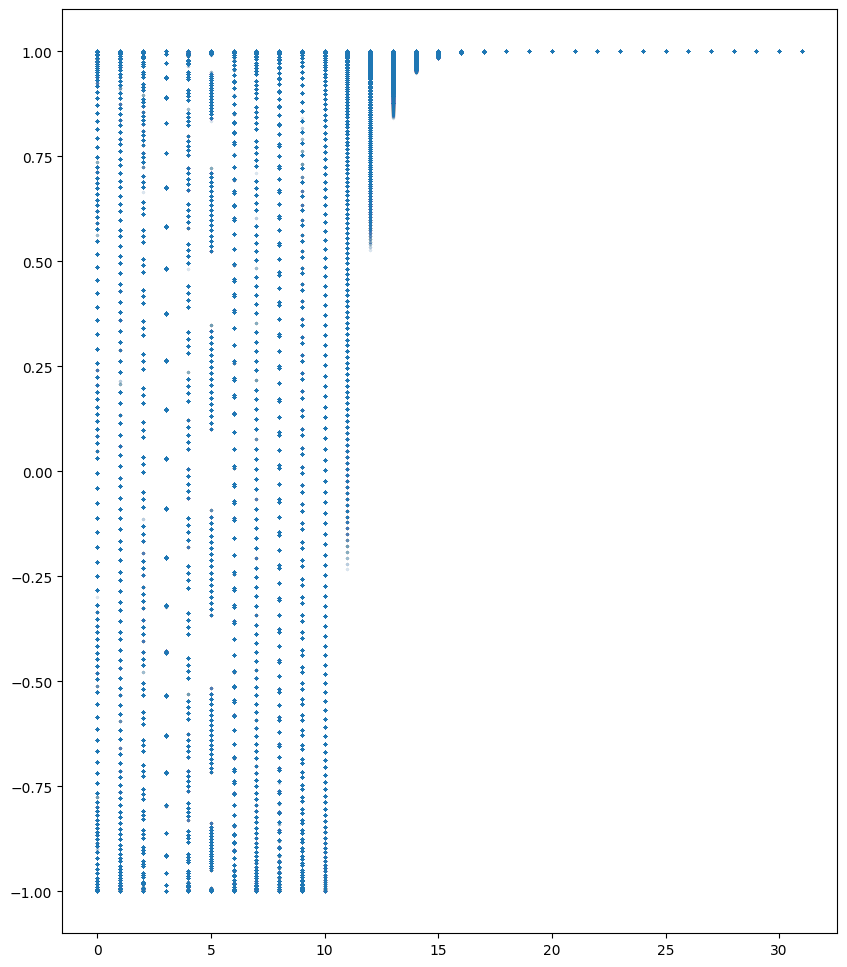

In [56]:
plt.figure(figsize=(10, 12))
plt.scatter(xx_train, yy_train, alpha=0.01, s=3)
#plt.scatter(xx_test, yy_test, alpha=0.005, s=3)
plt.show()

希望找到一种对于整数 x 的 encoding 方法 f(v, x)，使得编码后的向量满足以下性质：
- 能够对任意大小的整数的编码
- 整数 `[0,K)` 均匀分布在 d 维向量空间
- qk 向量内积后 <f(q, m),f(k,n)> = g(q, k, m-n)

想象常规进位制度，随着整数 x 的线性增长，主要的变化都集中在低位。高维的变化很少

- 给定向量维度 d （编码后位数），可以找到合适的进位(base)使训练序列长度 K 正好达到该进位下的最大值

给定一个整数 x -> 编码后变成一个向量 -> 目前基于进位思路的编码存在问题:当 x 产生微小的变化，向量仅少数维会发生变化